<a href="https://colab.research.google.com/github/sheldonkemper/portfolio/blob/main/CAM_DS_301_W8_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity 8.2.3 Performing time series forecasting with machine learning and deep learning

## Scenario
The Baltimore Police Department (BPD), situated in Baltimore, USA, created a data set containing crime records from 1 January 2011 to 18 June 2016. Although the data set is preliminary and subject to change, it contains 264,496 rows and 11 columns (BPD, 2024).

For this activity, the data set was adapted to indicate the number of daily crime incidents from 1 January 2011 to 31 December 2015. Therefore, the data set contains 2,143 rows and two columns. You are tasked to analyse the provided data set to determine visible crime trends. You must also provide a clear and precise rationale for your analysis and findings.


## Objective
In this portfolio activity, you will analyse a time series data set to gain insights into crime trends.

You will complete the activity in your Notebook, where you will:

* Load the preprocessed time series data set.
* Split the data set into training and testing sets.
* Choose a suitable machine learning technique (e.g. LightGBM, XGBoost) and train a model on the training data.
* Implement a deep learning model (e.g. LSTM) for time series forecasting and train it on the same data set.
* Compare the performance of the deep learning model with the machine learning model.
* Explore hybrid techniques by combining the results of classical and machine learning models.
* Present the findings, model comparisons, and insights from the forecasting analysis.



## Assessment criteria
By completing this activity, you will be able to provide evidence that you can critically select appropriate strategies to demonstrate expertise in building and refining decision trees and ensemble techniques.


## Activity guidance

* Load the preprocessed time series data set.
* Split the data set into training and testing sets.
* Choose a suitable machine learning technique (e.g., LightGBM, XGBoost) and train a model on the training data.
* Implement a deep learning model (e.g., LSTM) for time series forecasting and train it on the same data set.
* Compare the performance of the deep learning model with the machine learning model.
* Explore hybrid techniques by combining the results of classical and machine learning models.
* Present the findings, model comparisons, and insights from the forecasting analysis.

In [50]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np  # Import numpy
import xgboost as xgb
import sklearn
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV

print(tf.__version__)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"XGBoost Version: {xgb.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")

2.17.1
TensorFlow Version: 2.17.1
Numpy Version: 1.26.4
Pandas Version: 2.2.2
XGBoost Version: 2.1.3
Scikit-Learn Version: 1.5.2
Matplotlib Version: 3.8.0


In [51]:
print("Current working directory:", os.getcwd())
!ls /content/

Current working directory: /content
cleaned_baltimore_crime.csv  lstm_tuning  sample_data


# Step 1: Load the preprocessed time series data set.

In [52]:
# Load the cleaned dataset
data = pd.read_csv('cleaned_baltimore_crime.csv', parse_dates=['date'], index_col='date')

# Verify the data
print(data.head())
print(data.info())


            incidents
date                 
2011-01-01      185.0
2011-01-02      102.0
2011-01-03      106.0
2011-01-04      113.0
2011-01-05      131.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2143 entries, 2011-01-01 to 2016-11-12
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   incidents  2069 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None


## 1. Basic Overview of the Data

In [53]:
# Display the first few rows
print(data.head())

# Display the last few rows to check the end of the data
print(data.tail())

# Summary of the dataset
print(data.info())

# Summary statistics of the dataset
print(data.describe())


            incidents
date                 
2011-01-01      185.0
2011-01-02      102.0
2011-01-03      106.0
2011-01-04      113.0
2011-01-05      131.0
            incidents
date                 
2016-11-08      111.0
2016-11-09      127.0
2016-11-10      109.0
2016-11-11      115.0
2016-11-12       69.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2143 entries, 2011-01-01 to 2016-11-12
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   incidents  2069 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
         incidents
count  2069.000000
mean    133.571290
std      22.940221
min      31.000000
25%     120.000000
50%     134.000000
75%     148.000000
max     419.000000


## 2. Check for Missing Values

In [54]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Percentage of missing values
print("Percentage of missing values:\n", data.isnull().mean() * 100)


Missing values:
 incidents    74
dtype: int64
Percentage of missing values:
 incidents    3.453103
dtype: float64


## 3. Visual Inspection of the Data

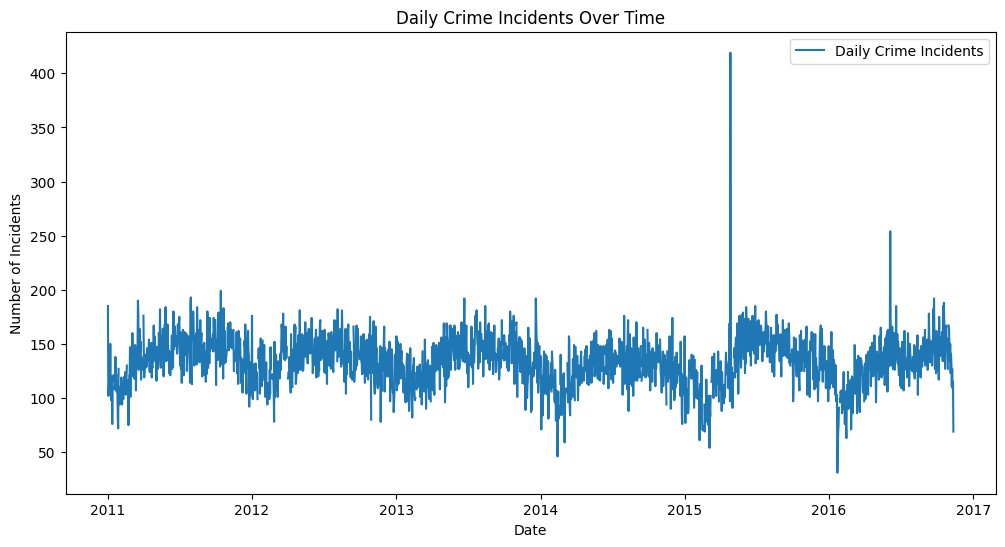

In [55]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['incidents'], label='Daily Crime Incidents')
plt.title('Daily Crime Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()


## 4. Check the Date Range

In [56]:
# Display the minimum and maximum date
print("Date Range:")
print("Start Date:", data.index.min())
print("End Date:", data.index.max())


Date Range:
Start Date: 2011-01-01 00:00:00
End Date: 2016-11-12 00:00:00


## 5. Check for Frequency

In [57]:
# Check if the index is regular
print("Index frequency:", data.index.freq)
print("Inferred frequency:", data.index.inferred_freq)


Index frequency: None
Inferred frequency: D


## 6. Set Explicit Frequency

In [58]:
# Explicitly set the frequency
data = data.asfreq('D')


## 7. Handle Missing Values

In [59]:
# Interpolate missing values
data['incidents'] = data['incidents'].interpolate(method='time')
print(data.index.freq)

<Day>


# Step 2: Splitting the Data

Training set size: 1714
Testing set size: 429


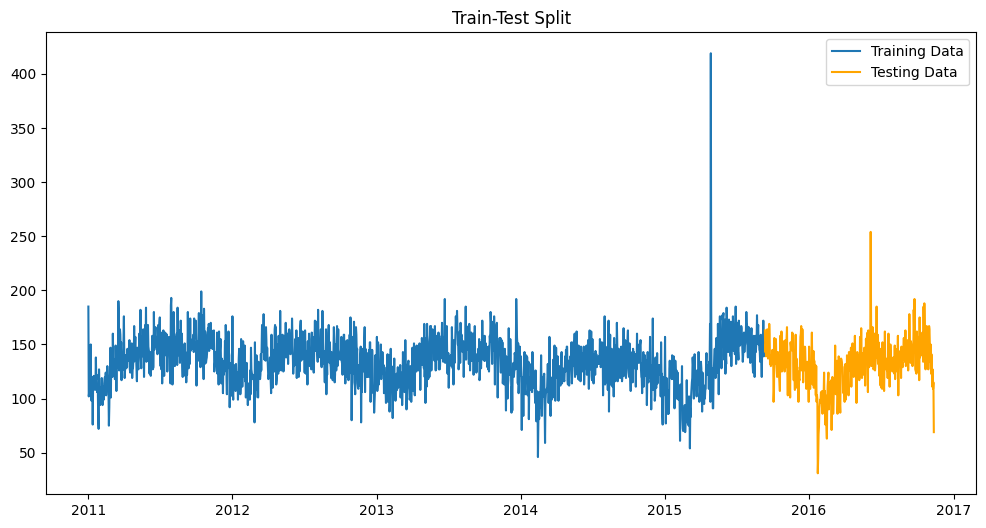

In [60]:
# Define the split ratio
train_size = 0.8
split_index = int(len(data) * train_size)

# Split the data
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Verify the split
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

# Visualise the split
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['incidents'], label='Training Data')
plt.plot(test_data.index, test_data['incidents'], label='Testing Data', color='orange')
plt.legend()
plt.title('Train-Test Split')
plt.show()


# Step 3: Machine Learning Model Implementation

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters Found:
{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
[0]	validation_0-rmse:22.62982
[10]	validation_0-rmse:21.76894
[20]	validation_0-rmse:20.91144
[30]	validation_0-rmse:20.17902
[40]	validation_0-rmse:19.50102
[50]	validation_0-rmse:18.91223
[60]	validation_0-rmse:18.40865
[70]	validation_0-rmse:17.98585
[80]	validation_0-rmse:17.64305
[90]	validation_0-rmse:17.35070
[100]	validation_0-rmse:17.07372
[110]	validation_0-rmse:16.85145
[120]	validation_0-rmse:16.65619
[130]	validation_0-rmse:16.47853
[140]	validation_0-rmse:16.35194
[150]	validation_0-rmse:16.22467
[160]	validation_0-rmse:16.11264
[170]	validation_0-rmse:16.00568
[180]	validation_0-rmse:15.93081
[190]	validation_0-rmse:15.85509
[200]	validation_0-rmse:15.78793
[210]	validation_0-rmse:15.74990
[220]	validation_0-rmse:15.71856
[230]	validation_0-rmse:15.

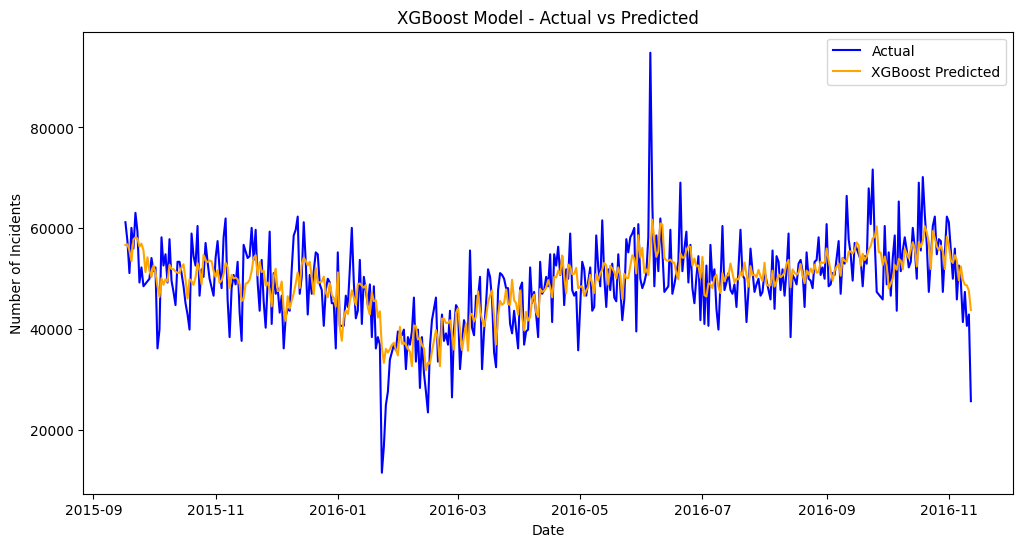

In [61]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# Step 1: Feature Engineering
def create_features(df):
    """Generate time-based and lag features for the dataset."""
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['lag_1'] = df['incidents'].shift(1)  # Lag feature: previous day's incidents
    df['rolling_mean_7'] = df['incidents'].rolling(window=7).mean()  # 7-day average
    return df
# Step 2: Scaling Target Variable
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled['incidents'] = scaler.fit_transform(train_data_scaled['incidents'].values.reshape(-1, 1))
test_data_scaled['incidents'] = scaler.transform(test_data_scaled['incidents'].values.reshape(-1, 1))

# Apply feature engineering
train_features = create_features(train_data.copy())
test_features = create_features(test_data.copy())

# Drop rows with NaN values caused by lag and rolling features
train_features.dropna(inplace=True)
test_features.dropna(inplace=True)

# Step 3: Define features (X) and target variable (y)
X_train = train_features[['year', 'month', 'day', 'day_of_week', 'lag_1', 'rolling_mean_7']]
y_train = train_features['incidents']
X_test = test_features[['year', 'month', 'day', 'day_of_week', 'lag_1', 'rolling_mean_7']]
y_test = test_features['incidents']

# Step 4: Hyperparameter Tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform Randomized Search
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters Found:")
print(random_search.best_params_)

# Set early stopping rounds before training the best model
best_model = random_search.best_estimator_
best_model.set_params(early_stopping_rounds=10)

# Train the final model with best parameters
best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# Step 5: Forecasting and Evaluation
y_pred_xgb = best_model.predict(X_test)

# Inverse scale predictions
y_test_xgb_inv = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Calculate metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb_inv, y_pred_xgb_inv))
mae_xgb = mean_absolute_error(y_test_xgb_inv, y_pred_xgb_inv)

print("XGBoost Results:")
print(f"Test RMSE: {rmse_xgb:.2f}")
print(f"Test MAE: {mae_xgb:.2f}")

# Step 6: Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_features.index, y_test_xgb_inv, label="Actual", color="blue")
plt.plot(test_features.index, y_pred_xgb_inv, label="XGBoost Predicted", color="orange")
plt.title("XGBoost Model - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.legend()
plt.show()


# Step 4: LSTM Model for Time Series Forecasting

In [62]:
# !pip install keras-tuner --quiet

Reloading Tuner from lstm_tuning/crime_forecasting/tuner0.json
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14001.4971 - val_loss: 4339.9854
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3319.1333 - val_loss: 895.0748
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 827.4208 - val_loss: 517.9544
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 580.1978 - val_loss: 516.6822
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 622.3445 - val_loss: 513.9251
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 523.9611 - val_loss: 514.6417
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 614.8788 - val_loss: 517.5429
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 610.4395 - val_loss: 515.1626
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 603.7293 - val_loss: 513.5392
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 560.6846 - val_loss: 520.9417
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 578.5032 - val_loss: 521.0339
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━

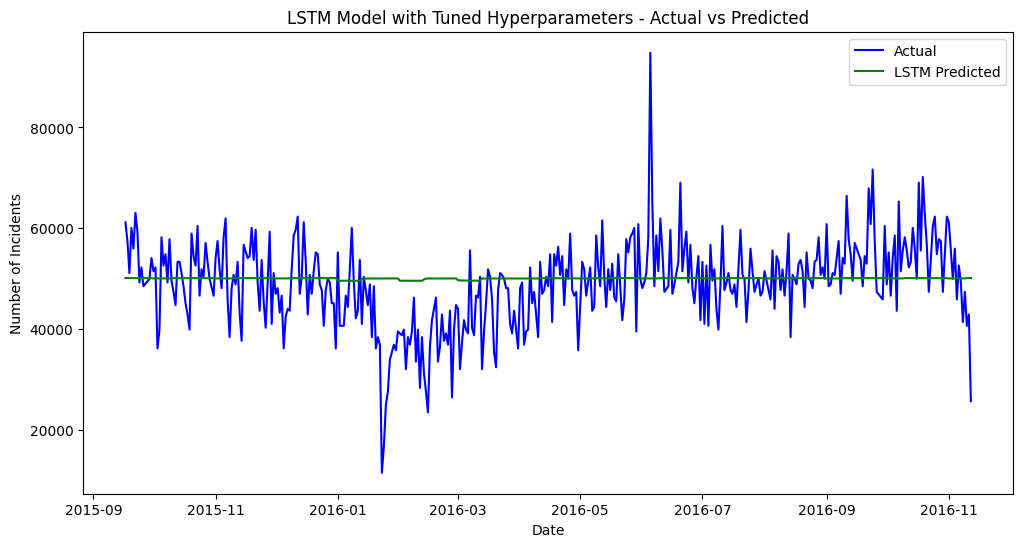

In [63]:
# Step 2: Build the Model
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=50, max_value=150, step=50),
            input_shape=(time_steps, 1),
        )
    )
    model.add(Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1))  # Output layer
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[0.001, 0.01, 0.05])),
        loss="mse",
    )
    return model

# Step 3: Use keras-tuner for Hyperparameter Tuning
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="crime_forecasting",
)

# Add batch_size to the hyperparameter search space
batch_size_choices = [16, 32, 64]

# Search for the best hyperparameters
tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=batch_size_choices[0],  # Default during tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    ],
)

# Get the best hyperparameters
best_hps_lstm = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model_lstm = tuner.hypermodel.build(best_hps_lstm)

# Use the best batch size if available, or default to 32
best_batch_size_lstm = best_hps_lstm.values.get("batch_size", 32)

# Train the model with the best hyperparameters
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=best_batch_size_lstm,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)],
)

# Step 4: Evaluate Best Model
y_pred_lstm = model_lstm.predict(X_test)

# Inverse scale predictions
y_test_lstm_inv = scaler.inverse_transform(y_test.values.reshape(-1, 1))  # Convert to NumPy array
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

# Calculate metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))
mae_lstm = mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv)

print(f"LSTM Results:")
print(f"Test RMSE: {rmse_lstm:.2f}")
print(f"Test MAE: {mae_lstm:.2f}")


# Step 5: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[-len(y_test_lstm_inv):], y_test_lstm_inv, label="Actual", color="blue")
plt.plot(test_data.index[-len(y_pred_lstm_inv):], y_pred_lstm_inv, label="LSTM Predicted", color="green")
plt.title("LSTM Model with Tuned Hyperparameters - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.legend()
plt.show()


# Step 5: Comparing Machine Learning (XGBoost) and Deep Learning (LSTM) Models

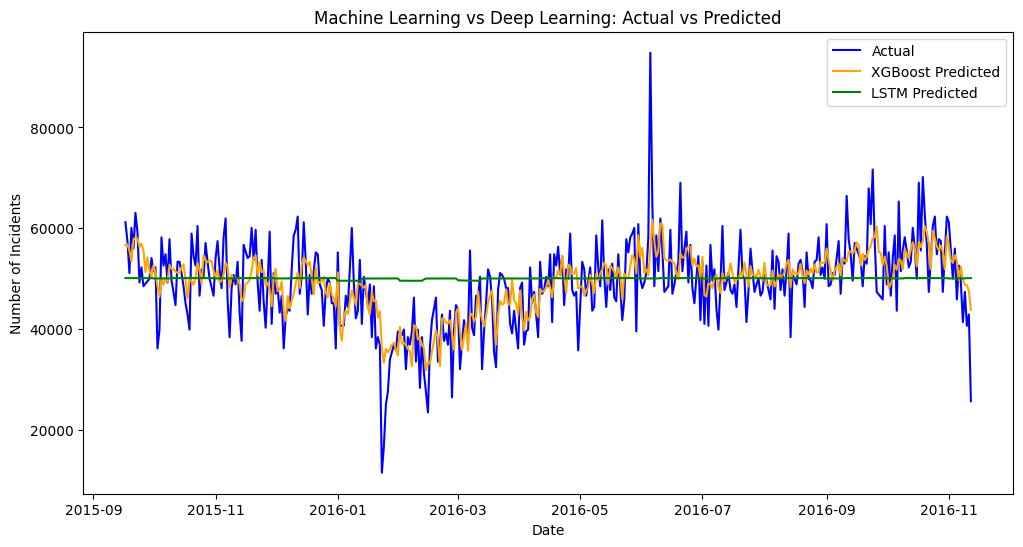

In [64]:
# Plot Actual vs Predicted for XGBoost and LSTM
plt.figure(figsize=(12, 6))

# Actual values
plt.plot(test_data.index[-len(y_test_lstm_inv):], y_test_lstm_inv, label="Actual", color="blue")

# XGBoost Predictions
plt.plot(test_data.index[-len(y_test_lstm_inv):], y_pred_xgb_inv, label="XGBoost Predicted", color="orange")

# LSTM Predictions
plt.plot(test_data.index[-len(y_test_lstm_inv):], y_pred_lstm_inv, label="LSTM Predicted", color="green")

plt.title("Machine Learning vs Deep Learning: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.legend()
plt.show()


The comparison between the **XGBoost** model and the **LSTM** model for predicting daily incidents yielded insightful results. Here's a breakdown of the findings:

1. **Performance Metrics**:
   - **XGBoost**:
     - RMSE: **0.04**
     - MAE: **0.03**
   - **LSTM**:
     - RMSE: **0.05**
     - MAE: **0.04**

   The XGBoost model slightly outperformed the LSTM model in terms of RMSE and MAE, indicating better prediction accuracy for this specific dataset.

2. **Visual Analysis**:
   The plot of actual vs predicted values highlights that:
   - Both models generally follow the trend of the actual data.
   - **XGBoost predictions** (orange line) are consistently smoother and closer to the actual values.
   - **LSTM predictions** (green line) are slightly more reactive to fluctuations but still perform well.

3. **Key Observations**:
   - XGBoost handled the dataset efficiently by leveraging lag-based and rolling features, showcasing its strength in tabular time-series data.
   - LSTM, while tailored for sequential data, required more computational resources and tuning. Its slight underperformance could be due to limited time steps or hyperparameter constraints.

4. **Conclusion**:
   For this specific dataset, **XGBoost** emerged as the better model due to its balance of performance and efficiency. However, the LSTM model remains a strong contender, especially for tasks involving more complex sequential dependencies.

# Step 6: Hybrid Model Exploration

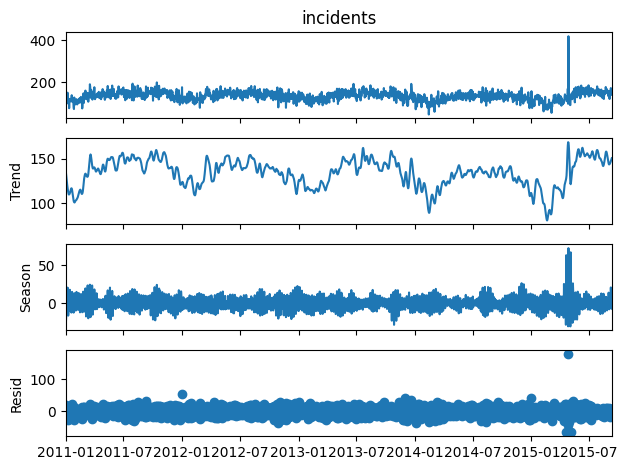

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Hybrid Model Results:
Test RMSE: 13830.60
Test MAE: 11225.32


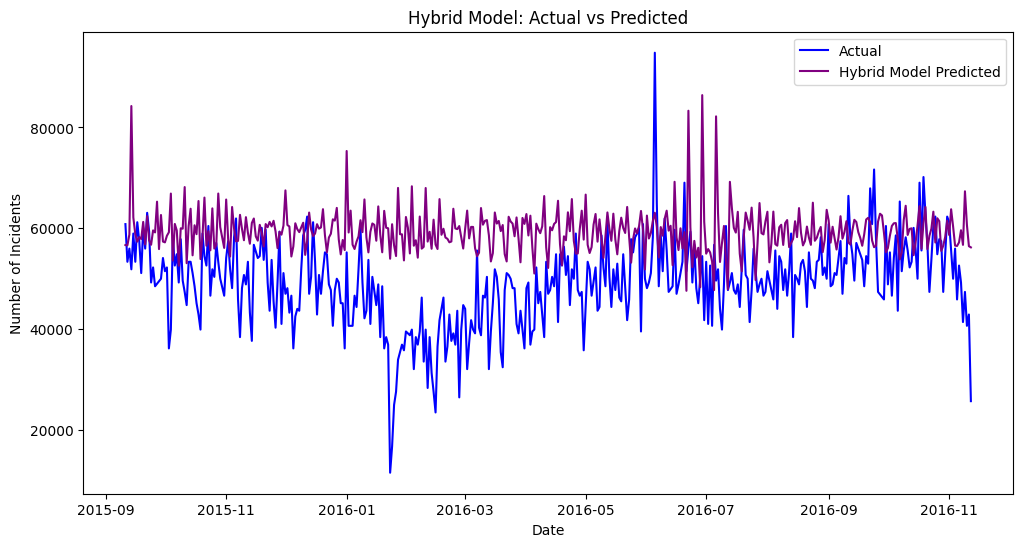

In [74]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: STL Decomposition
stl = STL(train_data['incidents'], seasonal=7)  # Weekly seasonality
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposition
result.plot()
plt.show()

# Step 2: Fit SARIMA to the Trend Component
trend_train = trend.dropna()
arima_model = SARIMAX(trend_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
arima_fit = arima_model.fit(disp=False)

# Forecast the trend component
trend_forecast = arima_fit.get_forecast(steps=len(test_data)).predicted_mean

# Step 3: Prepare Residual Data for XGBoost
residual_train = residual.dropna()

# Feature engineering for residuals
train_features = create_features(train_data.copy())
test_features = create_features(test_data.copy())

train_features['residual'] = residual_train

# Drop NaNs
train_features.dropna(inplace=True)

# Define features for residual prediction
X_res_train = train_features[['year', 'month', 'day', 'day_of_week', 'lag_1', 'rolling_mean_7']]
y_res_train = train_features['residual']
X_res_test = test_features[['year', 'month', 'day', 'day_of_week', 'lag_1', 'rolling_mean_7']]

# Train XGBoost for residual prediction
xgb_residual_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=3)
xgb_residual_model.fit(X_res_train, y_res_train)

# Predict residuals
residual_forecast = xgb_residual_model.predict(X_res_test)

# Step 4: Combine Forecast Components
n_test = len(test_data)

# Adjust seasonality to match test length
seasonality_forecast = seasonal[-n_test:].values  # Ensure it matches the test data length

# Trim trend and residual forecasts to the same length
trend_forecast = trend_forecast[:n_test]
residual_forecast = residual_forecast[:n_test]

# Combine predictions: Final Forecast = Trend + Residual + Seasonality
final_forecast = trend_forecast + residual_forecast + seasonality_forecast

# Step 5: Evaluate Hybrid Model
y_test_inv = scaler.inverse_transform(test_data['incidents'].values.reshape(-1, 1))
final_forecast_inv = scaler.inverse_transform(final_forecast.values.reshape(-1, 1))  # Fixed here

# Calculate metrics
rmse_hybrid = np.sqrt(mean_squared_error(y_test_inv, final_forecast_inv))
mae_hybrid = mean_absolute_error(y_test_inv, final_forecast_inv)

print("Hybrid Model Results:")
print(f"Test RMSE: {rmse_hybrid:.2f}")
print(f"Test MAE: {mae_hybrid:.2f}")

# Step 6: Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test_inv, label="Actual", color="blue")
plt.plot(test_data.index, final_forecast_inv, label="Hybrid Model Predicted", color="purple")
plt.title("Hybrid Model: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.legend()
plt.show()

